In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('crimes')

In [3]:
end2end_model = end2end_crps.train_model(x_train, y_train, n_epoch = 500, num_models = 5, hidden_layers = [50, 50], learning_rate = 0.001, tanh = True, calibration_threshold = .03, exp_decay = .998)

initial loss:  -0.2873275876045227
251 0.05082399999999998 tensor(-4.6302, grad_fn=<MeanBackward0>) tensor(0.0460, grad_fn=<MeanBackward0>)
253 0.053200444444444425 tensor(-4.6234, grad_fn=<MeanBackward0>) tensor(0.0461, grad_fn=<MeanBackward0>)
255 0.05866933333333328 tensor(-4.6312, grad_fn=<MeanBackward0>) tensor(0.0459, grad_fn=<MeanBackward0>)
257 0.0690364444444444 tensor(-4.6373, grad_fn=<MeanBackward0>) tensor(0.0458, grad_fn=<MeanBackward0>)
259 0.09802133333333331 tensor(-4.6170, grad_fn=<MeanBackward0>) tensor(0.0459, grad_fn=<MeanBackward0>)
260 0.04312177777777782 tensor(-4.5993, grad_fn=<MeanBackward0>) tensor(0.0458, grad_fn=<MeanBackward0>)
261 0.1308466666666666 tensor(-4.5706, grad_fn=<MeanBackward0>) tensor(0.0463, grad_fn=<MeanBackward0>)
262 0.04950177777777781 tensor(-4.5901, grad_fn=<MeanBackward0>) tensor(0.0458, grad_fn=<MeanBackward0>)
263 0.09773733333333333 tensor(-4.6096, grad_fn=<MeanBackward0>) tensor(0.0457, grad_fn=<MeanBackward0>)
265 0.064714222222222

374 0.031219555555555598 tensor(-4.9042, grad_fn=<MeanBackward0>) tensor(0.0413, grad_fn=<MeanBackward0>)
375 0.07908488888888886 tensor(-4.8914, grad_fn=<MeanBackward0>) tensor(0.0413, grad_fn=<MeanBackward0>)
376 0.03677377777777781 tensor(-4.8981, grad_fn=<MeanBackward0>) tensor(0.0413, grad_fn=<MeanBackward0>)
377 0.07775333333333329 tensor(-4.8935, grad_fn=<MeanBackward0>) tensor(0.0413, grad_fn=<MeanBackward0>)
379 0.06258666666666662 tensor(-4.9233, grad_fn=<MeanBackward0>) tensor(0.0409, grad_fn=<MeanBackward0>)
381 0.05742622222222221 tensor(-4.9366, grad_fn=<MeanBackward0>) tensor(0.0408, grad_fn=<MeanBackward0>)
383 0.06473911111111107 tensor(-4.9295, grad_fn=<MeanBackward0>) tensor(0.0409, grad_fn=<MeanBackward0>)
385 0.07119466666666664 tensor(-4.9211, grad_fn=<MeanBackward0>) tensor(0.0410, grad_fn=<MeanBackward0>)
386 0.03015600000000002 tensor(-4.9298, grad_fn=<MeanBackward0>) tensor(0.0409, grad_fn=<MeanBackward0>)
387 0.07271199999999996 tensor(-4.9254, grad_fn=<MeanB

End2end test MAPE:  0.6349283
End2end test RMSE:  0.13080569
End2end test NLLK:  5.1673384
End2end test CRPS:  tensor(0.0682)


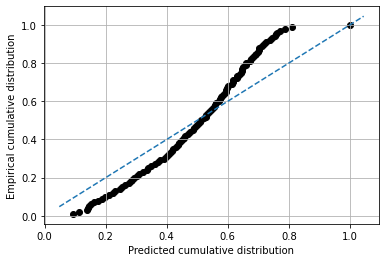

End2end test calibration error when step size is 0.001:  10.944602757057222
End2end test calibration error when step size is 0.01:  1.086735658241754
End2end test calibration error when step size is 0.1:  0.08845726581882671


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('End2end test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('End2end test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [5]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.52it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.40it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.67it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.087
  RMSE          0.131
  MDAE          0.054
  MARPD         46.380
  R2            0.656
  Correlation   0.818
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.202
  Mean-absolute Calibration Error       0.179
  Miscalibration Area                   0.181
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.233
     Group Size: 0.56 -- Calibration Error: 0.200
     Group Size: 1.00 -- Calibration Error: 0.179
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.279
     Group Size: 0.56 -- Calibration Error: 0.231
     Group Size: 1.00 -- Calibration Error: 0.202
===============

Lims is None. Setting lims now:
min_max_true: (0.0, 1.0)
min_max_pred: (0.012726575, 0.95164)
lims: (0.0, 1.0)
lims_ext: (-0.1, 1.1)


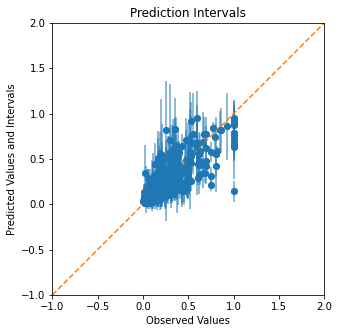

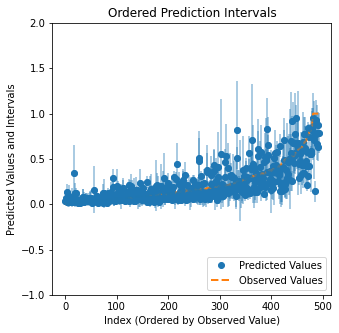

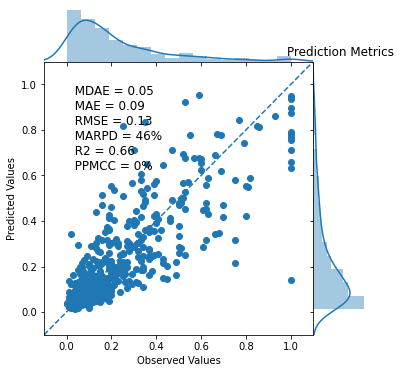

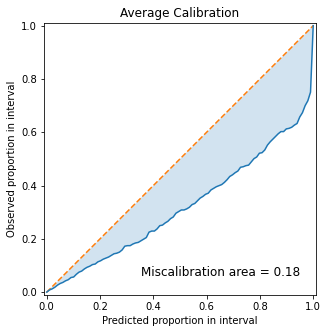

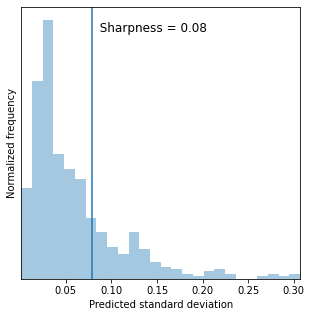

In [6]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))